# **Lista de exercícios 2**: Modelo Probabilístico de Regressão Linear

Prof. Dr. Rodrigo Colnago Contreras <br />
contreras@unifesp.br

Para a condução das práticas computacionais, é necessário instalar a biblioteca ```yfinance```:

In [ ]:
!pip install yfinance --upgrade --quiet

Sugere-se utilizar a função abaixo para confeccionar o dataframe com os ativos financeiros considerados.

In [ ]:
import yfinance as yf
import pandas as pd

def montar_dataframe_yfinance(inicio='2023-04-01', fim='2024-04-01'):
    ativos = {
        'BTC': 'BTC-USD', # Bitcoin
        'ETH': 'ETH-USD', # Etherium
        'SP500': '^GSPC', # Standard & Poor's 500, ou simplesmente S&P, trata-se de um índice composto por quinhentos ativos cotados nas bolsas de NYSE ou NASDAQ
        'DXY': 'DX-Y.NYB' # Índice do dolar americano
    }

    dfs = []
    for nome, ticker in ativos.items():
        print(f"\nBaixando dados de {nome} ({ticker})...")
        try:
            df_temp = yf.download(ticker, start=inicio, end=fim)
            if 'Close' not in df_temp.columns:
                print(f"⚠️ Dados indisponíveis para {ticker}. Ignorando.")
                continue
            df_temp = df_temp[['Close']].rename(columns={'Close': nome})
            df_temp['date'] = df_temp.index.date
            dfs.append(df_temp.reset_index(drop=True))
        except Exception as e:
            print(f"❌ Erro ao baixar {ticker}: {e}")

    if not dfs:
        raise ValueError("❌ Nenhum dado foi carregado com sucesso.")

    df_final = dfs[0]
    for df in dfs[1:]:
        df_final = pd.merge(df_final, df, on='date', how='inner')

    return df_final


Exemplo de coleta de ativos com a ```yfinance```:

In [ ]:
df_ativos = montar_dataframe_yfinance()
df_ativos


Baixando dados de BTC (BTC-USD)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Baixando dados de ETH (ETH-USD)...


[*********************100%***********************]  1 of 1 completed



Baixando dados de SP500 (^GSPC)...


[*********************100%***********************]  1 of 1 completed



Baixando dados de DXY (DX-Y.NYB)...


[*********************100%***********************]  1 of 1 completed


Price,BTC,date,ETH,SP500,DXY
Ticker,BTC-USD,,ETH-USD,^GSPC,DX-Y.NYB
0,27790.220703,2023-04-03,1810.297119,4124.509766,102.089996
1,28168.089844,2023-04-04,1871.005127,4100.600098,101.589996
2,28177.984375,2023-04-05,1909.114014,4090.379883,101.849998
3,28044.140625,2023-04-06,1872.922607,4105.020020,101.820000
4,29652.980469,2023-04-10,1911.207520,4109.109863,102.580002
...,...,...,...,...,...
244,63778.761719,2024-03-22,3333.687988,5234.180176,104.430000
245,69958.812500,2024-03-25,3590.883789,5218.189941,104.230003
246,69987.835938,2024-03-26,3587.504883,5203.580078,104.290001


## **Exercício 1:** Quais ativos dentre o preço de fechamento do bitcoin, da etherium, da SP500 e da DXY correlacionam-se de maneira aproximadamente linear?

**Dica**: Analise o *scatter plot* destes ativos.

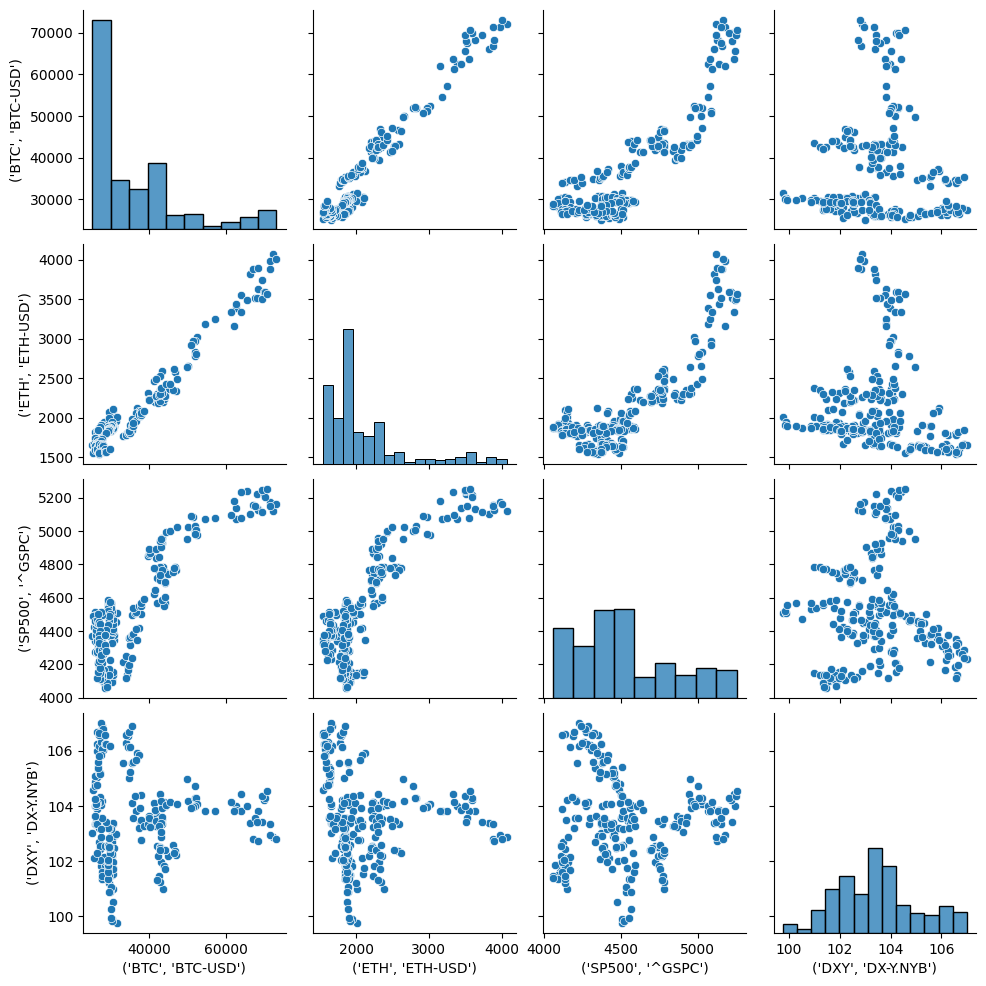

Price                BTC       ETH     SP500       DXY
Ticker           BTC-USD   ETH-USD     ^GSPC  DX-Y.NYB
Price Ticker                                          
BTC   BTC-USD   1.000000  0.972717  0.878024  0.006601
ETH   ETH-USD   0.972717  1.000000  0.838600 -0.098808
SP500 ^GSPC     0.878024  0.838600  1.000000 -0.018277
DXY   DX-Y.NYB  0.006601 -0.098808 -0.018277  1.000000


In [ ]:
# prompt: codigo para gerar grafico scatter pareado de um dataframe

import matplotlib.pyplot as plt
import seaborn as sns

# Criar o gráfico de dispersão pareado
sns.pairplot(df_ativos[['BTC', 'ETH', 'SP500', 'DXY']])
plt.show()

matriz_corr = df_ativos[['BTC', 'ETH', 'SP500', 'DXY']].corr()
print(matriz_corr)

**Resposta**: Segue que é possível identificar uma correlação linear entre as criptomoedas BTC e ETH (0.972717), BTC e SP500 (0.878024) e ETH e SP500 (0.838600). O valor entre parênteses é o coeficiente de correlação de Pearson, o qual indica a correlação linear entre as criptomoedas se o número resultante se aproximar de 1


## **Exercício 2:** Calcule a reta que descreve o preço de fechamento do BTC em função do preço de fechamento da ETH utilizando um MPRL determinado pelo método de mínimos quadrados. Analise a qualidade das métricas numéricas e visuais dessa aproximação.

**Dica:** Utilize as funções confeccionadas em sala de aula.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Intercepto: -7944.28939414378
Inclinação: 20.895204034520546
R²: 0.9469790939228772


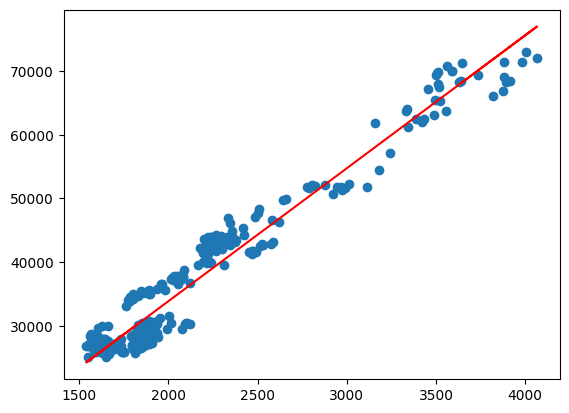

MSE: 7858568.816344502
MAE: 2421.704246662441
R²: 0.9469790939228772
Variância Explicada: 0.9469790939228772


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Baixar dados
btc_df = yf.download("BTC-USD", start="2023-04-01", end="2024-04-01")
eth_df = yf.download("ETH-USD", start="2023-04-01", end="2024-04-01")

# Garantir que estamos pegando Series com índice de datas
btc = btc_df['Close']
eth = eth_df['Close']

# Montar DataFrame com datas alinhadas
df = pd.concat([btc, eth], axis=1)
df.columns = ['BTC', 'ETH']
df.dropna(inplace=True)

# Variáveis X e y
X = df['ETH'].values.reshape(-1, 1)
y = df['BTC'].values

# Regressão linear
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Resultados
print("Intercepto:", modelo.intercept_)
print("Inclinação:", modelo.coef_[0])
print("R²:", modelo.score(X, y))

# Gráfico simples
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

print("MSE:", mean_squared_error(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("R²:", r2_score(y, y_pred))
print("Variância Explicada:", explained_variance_score(y, y_pred))



# Como interpretar as métricas:
| R²      | Interpretação                                 |
| ------- | --------------------------------------------- |
| ≈ 1.00  | O modelo explica **quase tudo**               |
| ≥ 0.80  | Ajuste muito bom                              |
| ≥ 0.50  | Ajuste razoável (útil em muitos casos)        |
| <  0.50 | Modelo fraco (não explica bem y)              |
| <  0.0  | O modelo é pior que simplesmente usar a média |

✅ 2. MSE – Erro Quadrático Médio
🔢 Valor:
Sempre positivo (ou zero)

Calculado com: mean_squared_error(y, y_pred)

📌 Interpretação:
"Média dos erros ao quadrado entre valores reais e previstos."

Penaliza fortemente erros grandes (porque eleva ao quadrado).

Útil quando grandes desvios são mais problemáticos (ex: finanças, saúde).

Quanto menor, melhor!

✅ 3. MAE – Erro Absoluto Médio
🔢 Valor:
Sempre positivo (ou zero)

Calculado com: mean_absolute_error(y, y_pred)

📌 Interpretação:
"Erro médio real que o modelo comete, sem considerar o sinal (positivo ou negativo)."

É mais robusto a outliers do que o MSE.

Fácil de interpretar: por exemplo, MAE = 100 → o modelo erra em média 100 unidades (BTC, por exemplo).

✅ Primeiro: o que são as métricas clássicas
Sigla	Nome	Fórmula
SQE	Soma dos Quadrados dos Erros
SQR	Soma dos Quadrados da Regressão
SQTQ	Soma Total dos Quadrados

✅ Relações com MAE e MSE
🔹 MSE (Erro Quadrático Médio)
# MSE = SQE/n
uma vez que SQE é a Soma dos Quadrados dos Erros MSE é a média ou seja SQE dividido por n
O MSE é apenas a SQE dividida pelo número de amostras, ou seja, a média dos quadrados dos erros.

🔹 MAE (Erro Absoluto Médio)
A MAE não tem uma relação direta com SQE/SQR/SQTQ, porque usa valores absolutos, não quadrados.

Mas ela serve como uma métrica alternativa de erro, geralmente mais intuitiva e robusta contra outliers.

✅ Relação geral entre as métricas:
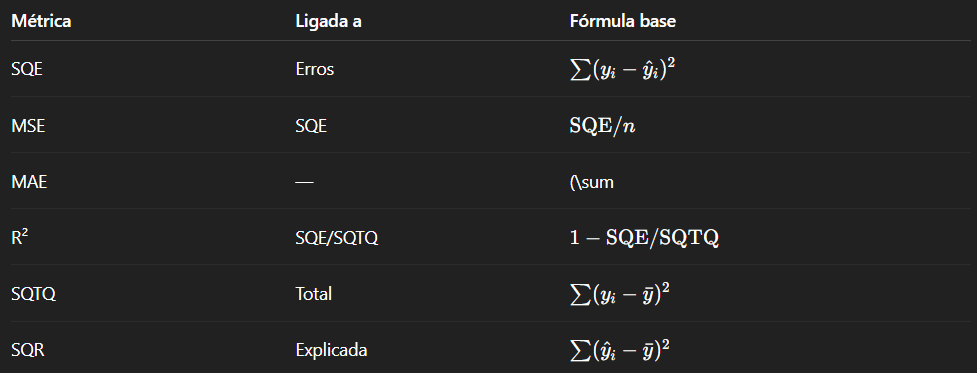
🧠 Dica final para prova:
SQE é o núcleo de MSE e R².

MSE = SQE / n

R² depende de quanto SQE representa da variância total (SQTQ)

MAE é independente, mas útil por ser mais interpretável.

## **Exercício 3:** Calcule a reta que descreve o preço de fechamento do BTC em função do preço de fechamento dos demais ativos coletados no Exercício 1 utilizando um MPRL múltiplo determinado pelo método de mínimos quadrados. Analise a qualidade das métricas numéricas e visuais dessa aproximação.

**Dica:** Utilize as funções confeccionadas em sala de aula.

## **Exercício 4:** Calcule a reta que descreve o preço de fechamento do ETH em função do preço de fechamento dos ativos SP500 e DXY coletados no Exercício 1 utilizando um MPRL múltiplo determinado pelo método de mínimos quadrados.

(a) Analise a qualidade das métricas numéricas e visuais dessa aproximação.

(b) Colete valores de 02 a 10 de abril de 2024 para os ativos coletados no Exercício 1 e os armazene em um *dataframe* ```df_teste```.

(c) Utilizando valores de SP500 e DXY referente ao período mencionado no item (b) anterior, estime os valores de ETH.

## **Exercício 5:** Refaça o exercício anterior considerando prever o preço do BTC em vez do preço da ETH.

## **Exercício 6:** Adicione duas variáveis ao dataframe ```df_ativos``` que consistem na resposta logarítmica dos valores de fechamento do BTC e da ETH.

(a) Ajuste um modelo de regressão linear com $\log(\text{BTC})$ como variável resposta e $\log(\text{ETH})$ como preditor.

(b) Compare com o modelo linear simples do Exercício 2.

(c) Qual teve melhor ajuste? Os resíduos são mais apropriados? Justifique.

## **Exercício 7:** Investigue como a presença de covariáveis altamente correlacionadas afeta o desempenho e a confiabilidade de um modelo de regressão linear múltipla. Especificamente, avalie o impacto da **multicolinearidade** entre variáveis explicativas no MPRL.

**(a)** Crie uma nova variável chamada `ETH_noise`, somando um pequeno ruído gaussiano ao preço de fechamento do Ethereum:


$$ \text{ETH}_\text{noise} = \text{ETH}+\text{noise}. $$

**(b)** Ajuste um modelo de regressão linear múltipla para descrever o preço do Bitcoin (BTC) em função de ETH e ETH_noise:

$$ \text{BTC} ≈ \beta_0 + +\beta_1\cdot \text{ETH} + \beta_2 \cdot \text{ETH}_\text{noise}. $$

**(c)** Analise e discuta:

- O valor de $ R^2 $ continua alto?  
- Os **coeficientes estimados** para `ETH` e `ETH_noise` são razoáveis ou parecem instáveis?  
- Algum coeficiente **perde significância estatística**?
- O que isso diz sobre a confiabilidade do modelo?

---

### 💬 Reflexão final:

> "Por que a presença de variáveis redundantes (altamente correlacionadas) pode ser prejudicial para o modelo de regressão linear? Como poderíamos mitigar esse problema?"